# Playground for Clustering

Use MiniBatchKMeans, tryout with subset of original data

## Load Data

In [53]:
import pandas as pd
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt #easy plotting: subpackage of seaborn
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA

# consts
VECTOR_PATH = '../data/customer_cluster/customer_vectors.npy'
CUSTOMER_ID_PATH = '../data/customer_cluster/customer_ids.txt'
COMMENT_PATH = '../data/csv/comments.csv'
NUM_DATA = 100000
RANDOM_STATE = 16


In [21]:
vector_data = []
with open(VECTOR_PATH, 'rb') as f:
    for i in range(NUM_DATA):
        vector_data.append(np.load(f))

## Determine K

Elbow method

In [ ]:
inertias = []
for k in range(1, 21):
  kmeans = MiniBatchKMeans(
    n_clusters=k, 
    random_state=RANDOM_STATE,
    max_iter=100,
    batch_size=1024,
  ).fit(vector_data)
  inertias.append(kmeans.inertia_)

Text(0.5, 1.0, 'elbow plot')

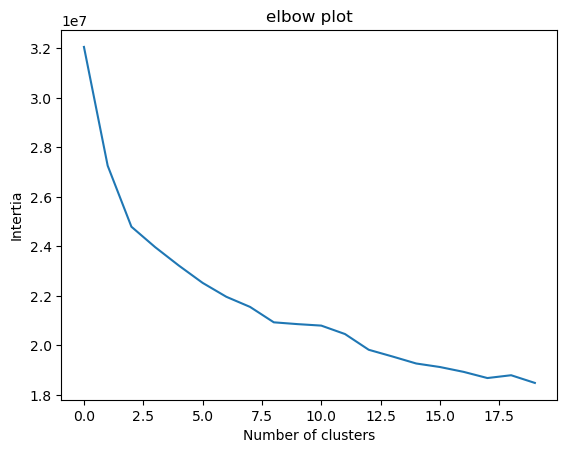

In [23]:
plt.plot(inertias)
plt.xlabel("Number of clusters")
plt.ylabel("Intertia")
plt.title("elbow plot")

From the elbow plot, k=6 is a reasonable number.

## Visualize Clusters with PCA

Use PCA to reduce the vectors to 2 dimensions, and use the clustering result to visualize clusters.

In [61]:
pca = PCA(2)
pca_data = pca.fit_transform(vector_data)

pca_data.shape

(100000, 2)

In [64]:
k = 6

kmeans = MiniBatchKMeans(
    n_clusters=k, 
    random_state=RANDOM_STATE,
    max_iter=100,
    batch_size=1024,
)
labels = kmeans.fit_predict(vector_data)

labels.shape

/data/conda/env/bogo/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


(100000,)

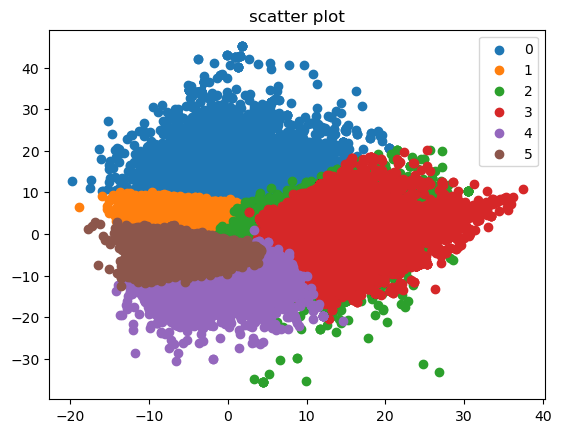

In [65]:
for i in range(k):
    plt.scatter(pca_data[labels == i, 0] , pca_data[labels == i , 1] , label = i)
plt.legend()
plt.title('scatter plot')
plt.show()

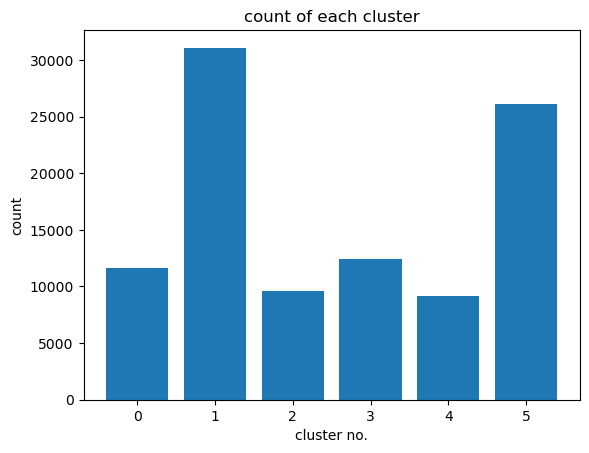

In [66]:
bar_x = range(k)
bar_y = []
for i in range(k):
    bar_y.append(sum(labels == i))
plt.bar(bar_x, bar_y)
plt.xlabel("cluster no.")
plt.ylabel("count")
plt.title('count of each cluster')
plt.show()

From counter of each cluster, it seams that when viewing in 2d, some clusters are overlapping, especially 1 & 5.

## Analyze Characteristics of Each Cluster

Select customers' comments from each cluster to see if common characteristic can be found.

The customers chosen should be as close to the cluster center as possible.

However as we won't load the entire dataset, the selected comments may not be the ones most distinctive to characterize.

In [57]:
comment_df = pd.read_csv(COMMENT_PATH, nrows=NUM_DATA * 10)


In [75]:
customer_ids = []
clustered_customers = [] # key is cluster id, each elem is a list of customer ids
clustered_distances = [] # key is cluster id, each elem is a list of customer distance to cluster center
for i in range(k):
    clustered_customers.append([])
    clustered_distances.append([])
with open(CUSTOMER_ID_PATH) as f:
    for idx, line in enumerate(f):
        if idx >= NUM_DATA:
            break
        customer_id = line.strip()
        clustered_customers[labels[idx]].append(customer_id)
        clustered_distances[labels[idx]].append(np.linalg.norm(vector_data[idx] - kmeans.cluster_centers_[labels[idx]]))
for i in range(k):
    print(f'cluster {i} has {len(clustered_customers[i])} customers')

cluster 0 has 11658 customers
cluster 1 has 31089 customers
cluster 2 has 9601 customers
cluster 3 has 12406 customers
cluster 4 has 9150 customers
cluster 5 has 26096 customers


In [78]:
import random

for i in range(k):
    print(f'Randomly nearest customer comments from cluster {i}')
    length = len(clustered_customers[i])
    sorted_indices = np.argsort(clustered_distances[i])
    counter = 0
    for idx in sorted_indices:
        customer_id = clustered_customers[i][idx]
        comments = comment_df[comment_df['customerId'] == customer_id]
        if not len(comments): 
            # may not retrieve comment, due to only a portion of comments is loadeds
            continue
        print(f"Customer #{customer_id}: {comments.iloc[0]['review']}")
        print(f"Summary: {comments.iloc[0]['summary']}")
        print(f"Distance: {clustered_distances[i][idx]}")
        counter += 1
        if counter == 15:
            break
    print('\n')

Randomly nearest customer comments from cluster 0
Customer #A10Z5UNH747W8L: Great movie and good to give as a gift
Summary: Five Stars
Distance: 5.896466694551321
Customer #A12XT6643J7XGI: great movie
Summary: Five Stars
Distance: 6.550621376471374
Customer #A12CWFFQFH847T: Great video
Summary: Five Stars
Distance: 6.57154975043626
Customer #A119NP6QAB5N2V: I've seen this movie for the first time a month ago and was blown away!!! Non-stop action, great story, great acting.  I've seen this movie over 3 times with friends and relatives since I bought it!
Summary: Has to be one of the Top 10 Greatest Action Movies of All Time!!!
Distance: 6.5789493489078215
Customer #A120V4KAPFTXLW: Great Movie from the 80's
Summary: Five Stars
Distance: 6.775762816457931
Customer #A1305WFC759AHB: It brings back so many memories of good times past. All those who was around when the movie was out. So many who are No longer here.
Summary: Good memories
Distance: 6.830584684044784
Customer #A12ZL8DGRMH2O3: C

From the limited comments retrieved above, can already see some common characteristics in the clusters:

- Cluster #0: give very positive reviews
- Cluster #1: love classic films, often purchase DVDs
- Cluster #2: love animation & comedy, probably have children around
- Cluster #3: love sophisticated films
- Cluster #4: love classic films
- Cluster #5: love comedy